## Evaluate the performance of the official link classifier with cross-validation

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

# Load the traning data woth the features previously extracted
training_set = pd.read_pickle("data/official_links_training_data.pkl")
training_set.head()

,index,context,features,link,link_path,official,page_id,title
0,0,Website,"[0.0, 1, 0, 1, 0.044444444444444446, 0.0465116...",nasedkin-badanina.com,/,1,39463634,Tatiana Badanina
1,1,,"[0.03571428571428571, 15, 0, 67, 0.0, 0.0, 0.0...",www.uniprot.org,/uniprot/P32780,1,14989135,GTF2H1
2,2,Website,"[0.0, 1, 0, 1, 0.48, 0.42857142857142855, 0.04...",www.mansory.com,/,1,15677351,Mansory
3,3,WebsiteOfficial websiteOfficial Facebook,"[0.06521739130434782, 11, 0, 3, 0.48, 0.09375,...",www.twitter.com,/BigRedyyc/,1,23075134,Diane Colley-Urquhart
4,4,Website,"[0.0, 0, 0, 1, 0.48, 0.42857142857142855, 0.04...",www.hcch.net,,1,1730612,Hague Conference on Private International Law


In [2]:
len(training_set)

2000

In [3]:
# Features
X = np.array(training_set['features'].tolist())
# Labels
y = training_set['official']

Evaluate the performance with 5-folds cross-validation

In [4]:
scoring = ['precision_macro', 'recall_macro', 'f1_macro']
clf = RandomForestClassifier(max_depth=10, random_state=42)
scores = cross_validate(clf, X, y, scoring=scoring, cv=5)
print("Precision: %0.2f (+/- %0.2f)" % (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std() * 2))

Precision: 0.96 (+/- 0.02)
Recall: 0.96 (+/- 0.01)
F1: 0.96 (+/- 0.01)


### ROC Curves

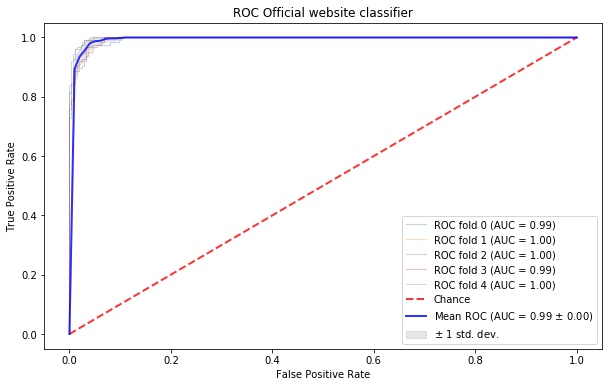

In [5]:
cv = StratifiedKFold(n_splits=5)
classifier = RandomForestClassifier(max_depth=10, random_state=0)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10, 6))
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC Official website classifier")
ax.legend(loc="lower right")
plt.show()